In [301]:
# Scientific libraries
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd

#astro

%matplotlib notebook
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
plt.style.use('mike')
jtplot.style(context='notebook', fscale=1, ticks=True, grid=False)
wine='#8F2727'
tree='#175656'
from betagen import betagen
dark, dark_highlight, mid, mid_highlight, light, light_highlight = betagen(wine)

import seaborn as sns
import emcee

from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')


# Function definitions

In [302]:
def photon_model(energy, K):
    """
    This is a constant photon model. Maybe faster if written in COBOL.
    """
    
    return K


def generate_counts_from_two_bins(K, eff_area_a, eff_area_b, miscalibration_constant_a = 1., miscalibration_constant_b = 1.):
    """
    Generate Poisson distributed events from a constant photon model detected by 
    two "instruments" which are treated as two different bins with possibly miscalibrated 
    effective areas.
    """
    
    # hard coded photon model side of the energy bins
    
    ebounds_a = np.array([10, 300])
    ebounds_b = np.array([50, 1000])

    
    # compute the latent counts folded thru the response

    expected_counts_a = eff_area_a * miscalibration_constant_a* integrate.quad(lambda x: photon_model(x, true_K),ebounds_a[0], ebounds_a[-1] )[0]
    expected_counts_b =  eff_area_b * miscalibration_constant_b * integrate.quad(lambda x: photon_model(x, true_K),ebounds_b[0], ebounds_b[-1] )[0]

    # draw Poissson distributed counts. There is no background here. So no GW detections!
    
    detected_counts_a = stats.poisson.rvs(expected_counts_a)
    detected_counts_b = stats.poisson.rvs(expected_counts_b)
    
    return detected_counts_a, detected_counts_b
    
    
def log_poisson_likelihood(model_counts, observed_counts):
    """
    log Poisson likelihood for no background and using Stirling approximation
    """
    
    return -2*(model_counts - observed_counts + observed_counts*(np.log(observed_counts) - np.log(model_counts) ))
    
       

## Specific set variables

Here we specify the effective area of the "instruments"


In [303]:
eff_area_a = .1
eff_area_b = .5
true_K = 1.

ebounds_a = np.array([10, 300])
ebounds_b = np.array([50, 1000])



# Perfectly calibrated instruments

In [330]:
np.random.seed(1234)

obs_counts_a, obs_counts_b = generate_counts_from_two_bins(true_K, eff_area_a, eff_area_b)

## Build the log posterior of the problem
    

In [331]:
def lnlike_nocal(theta, obs_counts_a, obs_counts_b, eff_area_a, eff_area_b):
    
    logK = theta
    
    # compute the model 
    model_counts_a = eff_area_a * integrate.quad(lambda x: photon_model(x, 10**logK),ebounds_a[0], ebounds_a[-1] )[0]
    model_counts_b = eff_area_b * integrate.quad(lambda x: photon_model(x, 10**logK),ebounds_b[0], ebounds_b[-1] )[0]
    
    # get the total likelihood 
    return log_poisson_likelihood(model_counts_a, obs_counts_a) + log_poisson_likelihood(model_counts_b, obs_counts_b)

In [309]:
def lnprior_nocal(theta):
    logK = theta
    
    # simple flat log prior
    if -2. < logK < 2.:
        return 0.0
    return -np.inf

def lnprob_nocal(theta, obs_counts_a, obs_counts_b, eff_area_a, eff_area_b):
    lp = lnprior_nocal(theta)

    if not np.isfinite(lp):
        return -np.inf

    return lp +lnlike_nocal(theta, obs_counts_a, obs_counts_b, eff_area_a, eff_area_b)


## Sample

We are going to do some relatively simple Bayesian analysis.

In [305]:
ndim, nwalkers = 1, 500

# init the sampling positions
pos = [0.+ 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_nocal, args=(obs_counts_a, obs_counts_b, eff_area_a, eff_area_b))
sampler.run_mcmc(pos, 500);

# pull out some nice samples
samples = sampler.chain[:, 250:, :].reshape((-1, ndim))

<IPython.core.display.Javascript object>


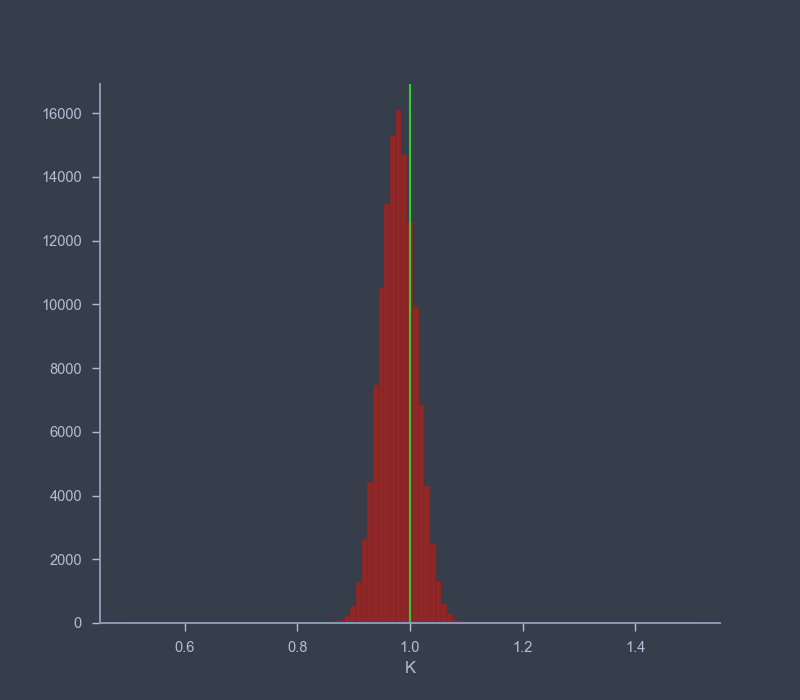

In [306]:
fig, ax = plt.subplots()


bins = np.linspace(.5,1.5,100)

ax.hist(10**samples[:,0],bins=bins,ec=dark_highlight,fc=dark);

ax.set_xlabel('K')
ax.axvline(true_K,color='limegreen')



# With calibration mistakes

Imagine that whoever calibrated the ACS made mistakes or lost the files for the threshold settings.

Now we screw up the effective areas such that what we think is correct is not. Thus, the inferred parameter(s) of the model will be biased.

In [323]:
np.random.seed(1234)

obs_counts_a, obs_counts_b = generate_counts_from_two_bins(true_K, eff_area_a, eff_area_b,
                                                           miscalibration_constant_a=.9, miscalibration_constant_b=1.3)

First we just sample assuming everything is fine

In [324]:
ndim, nwalkers = 1, 100
pos = [0.+ 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_nocal, args=(obs_counts_a, obs_counts_b, eff_area_a, eff_area_b))
sampler.run_mcmc(pos, 500);
samples = sampler.chain[:, 250:, :].reshape((-1, ndim))

<IPython.core.display.Javascript object>


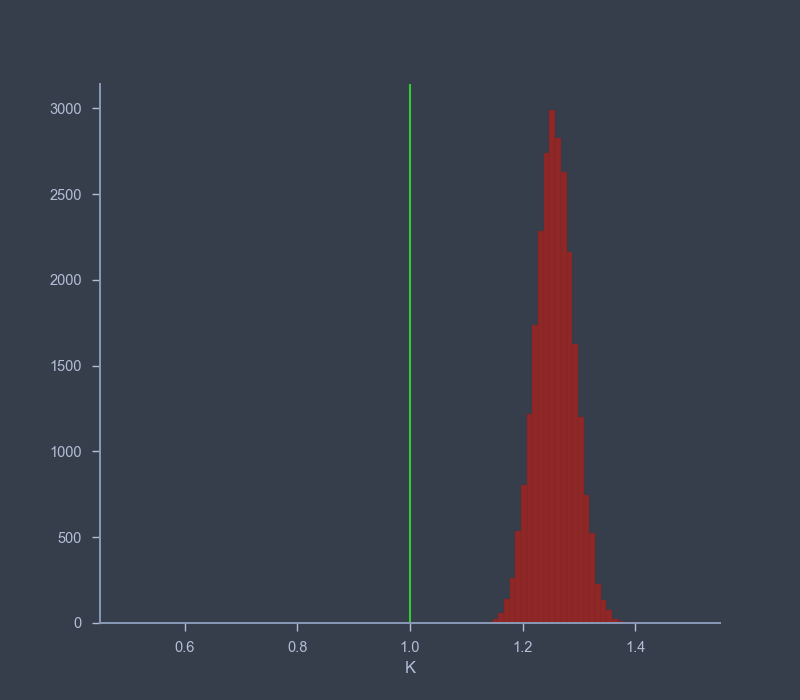

In [325]:
fig, ax = plt.subplots()



bins = np.linspace(.5,1.5,100)

ax.hist(10**samples[:,0],bins=bins,ec=dark_highlight,fc=dark);


ax.set_xlabel('K')
ax.axvline(true_K,color='limegreen')



## Add the calibration as a parameter

We will use the same likelihood as before but add our uncertainty about the calibration in as a free parameter. 

In [326]:
def lnlike_cal(theta, obs_counts_a, obs_counts_b, eff_area_a, eff_area_b):
    logK, log_calib_const = theta
    
    model_counts_a = eff_area_a * integrate.quad(lambda x: photon_model(x, 10**logK),ebounds_a[0], ebounds_a[-1] )[0]
    
    # we add the calibration constant on to one of the instruments
    model_counts_b = eff_area_b * 10**log_calib_const * integrate.quad(lambda x: photon_model(x, 10**logK),ebounds_b[0], ebounds_b[-1] )[0]
    
    return log_poisson_likelihood(model_counts_a, obs_counts_a) + log_poisson_likelihood(model_counts_b, obs_counts_b)


def lnprior_cal(theta):
    logK, log_calib_const = theta
    
    # log flat priors for both parameters
    
    if (-1. < logK < 1.) and (-1. < log_calib_const < 1.):
        return 0.0
    return -np.inf


def lnprob_cal(theta, obs_counts_a, obs_counts_b, eff_area_a, eff_area_b):
    lp = lnprior_cal(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp +lnlike_cal(theta, obs_counts_a, obs_counts_b, eff_area_a, eff_area_b)



In [327]:
ndim, nwalkers = 2, 500
pos = [0+ 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_cal, args=(obs_counts_a, obs_counts_b, eff_area_a, eff_area_b))
sampler.run_mcmc(pos, 500);

samples_with_cal = sampler.chain[:, 250:, :].reshape((-1, ndim))

<IPython.core.display.Javascript object>


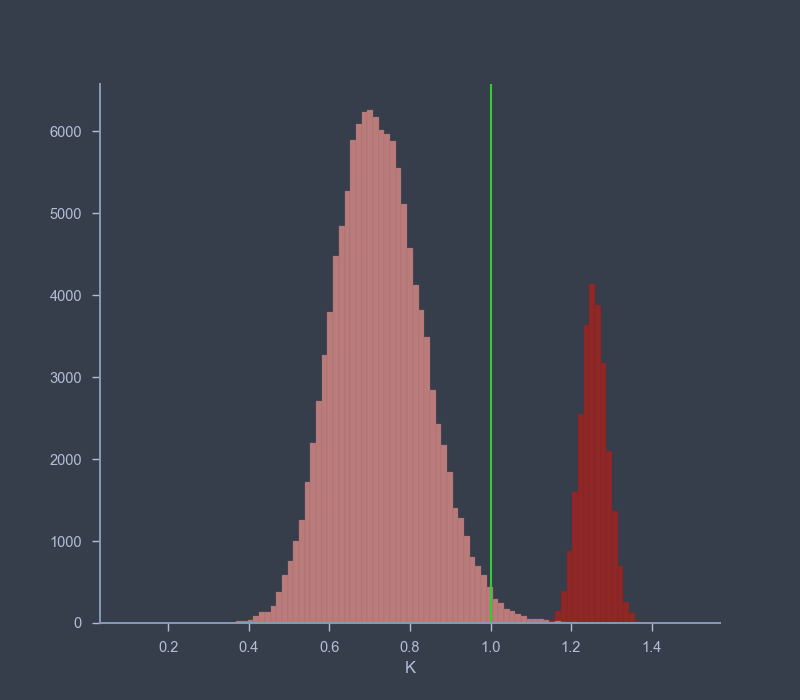

In [328]:
fig, ax = plt.subplots()



bins = np.linspace(.1,1.5,100)

ax.hist(10**samples[:,0],bins=bins,ec=dark_highlight,fc=dark);
ax.hist(10**samples_with_cal[:,0],bins=bins,ec=mid_highlight,fc=mid);

ax.set_xlabel('K')
ax.axvline(true_K,color='limegreen')



So we see that we can "begin" to recover the true value. This is an extreme case in the sense that the model there is not a lot of information in the model, the instruments, or the data. But even in this simple example, we can recover the true value if we parameterize our uncertainties. I think we can do some simulations with the real responses to assess this further. 

<IPython.core.display.Javascript object>


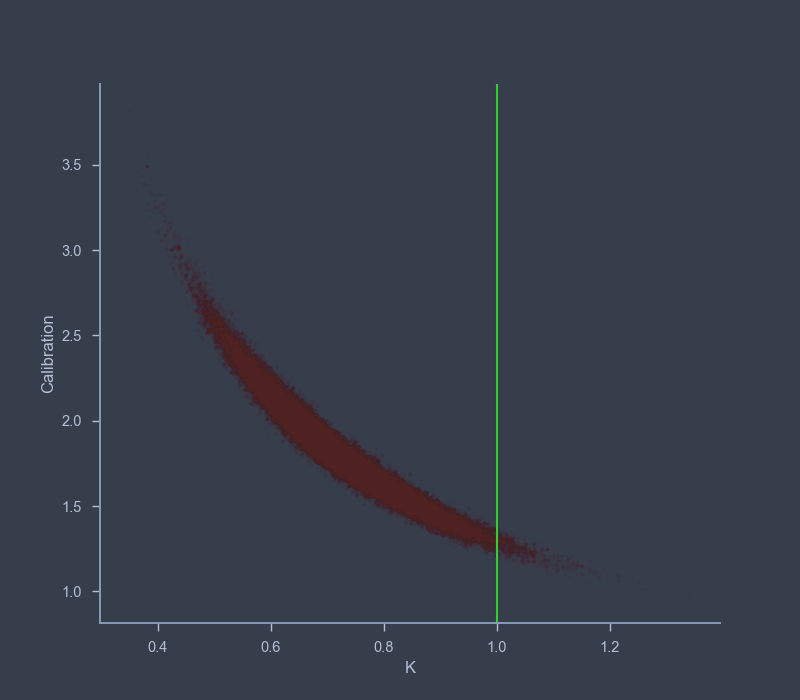

Text(0.5, 0, 'K')

In [329]:
fig, ax = plt.subplots()


ax.scatter(10**samples_with_cal[:,0],10**samples_with_cal[:,1],alpha=.025,c=dark_highlight,s=5)


ax.axvline(true_K,color='limegreen')

ax.set_ylabel('Calibration')
ax.set_xlabel('K')